# Investigating adjusted p-values from 625ppm vs 1500ppm eQTL analysis

__Author:__ Bryan Quach  
__Date:__ May 2, 2017

### Estimated Analysis Time: <1 days

## Objective

There are multiple objectives of this analysis. The main goal is to apply multiple testing correction to the initial results of the eQTL analyses (unadjusted p-values). Following the multiple testing correction, we will address the following questions:

* What is the q-value distribution of our results?
* How many gene-marker pairs produced a significant association?
* How many statistically significant eQTL-containing genes (eGenes) are observed?
* Which gene and marker comparisons produced the most significant hits?
* Which genes tested are eGenes?

## Software required

* [dplyr (R package)](https://cran.r-project.org/web/packages/dplyr/index.html)
* [qvalue (R package)](https://www.bioconductor.org/packages/release/bioc/html/qvalue.html)
* [GenomicRanges (R package)](https://bioconductor.org/packages/release/bioc/html/GenomicRanges.html)

## The Data

The data that we work with are results output from running a modified version of Daniel Oreper's eQTL analysis software. This software produces an R data file containing the environment in which the analysis was run, which includes a matrix of p-values with rows and columns corresponding to genes and markers respectively. In this analysis, we will look at results for the eQTL analyses in lung, liver, and kidney. The phenotype was the fold change of normalized expression (TPM) between 1500ppm and 625ppm BD treated CC mice.

## Global multiple testing correction

We apply [FDR correction](https://en.wikipedia.org/wiki/False_discovery_rate) to the p-values from all association tests. The resulting q-values will be used for assessing significance of all gene-marker pairs at a specified threshold. To aid in data analysis, we will convert our matrices of p-values into a data frame with `NA` values removed.

In [1]:
library(dplyr)
library(qvalue)
library(GenomicRanges)

# Function for retrieving non-NA values from matrix
#
# Args:
#   haystack - matrix to search through
#
# Returns a dataframe of the p-values with gene and marker names listed
reshape.results <- function(haystack){
    hits <- which(!is.na(haystack), arr.ind=T)
    rnames <- rownames(haystack)[hits[,1]]
    cnames <- colnames(haystack)[hits[,2]]    
    pvals <- sapply(1:nrow(hits), function(i){haystack[hits[i,1], hits[i,2]]})
    results <- data.frame(gene=rnames, marker=cnames, pval=as.numeric(pvals))
    results <- results[order(results$gene),]
    return(results)
}

#Get p-value matrices for each tissue
tmp.env <- new.env()
load("data/625ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
matrix.lung <- get("out.mat", tmp.env)
load("data/625ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
matrix.liver <- get("out.mat", tmp.env)
load("data/625ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
matrix.kidney <- get("out.mat", tmp.env)
rm(tmp.env)

#Reshape
pvals.lung <- reshape.results(matrix.lung)
pvals.liver <- reshape.results(matrix.liver)
pvals.kidney <- reshape.results(matrix.kidney)

#Apply FDR correction
qvals.lung <- qvalue(pvals.lung$pval, fdr.level=0.1) 
qvals.liver <- qvalue(pvals.liver$pval, fdr.level=0.1)
qvals.kidney <- qvalue(pvals.kidney$pval, fdr.level=0.1)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, len

## Identifying significant eGenes

For downstream analyses that focus only on the gene-level results, we will assign a representative p-value for each gene. A common approach to do this is to use the smallest p-value for a gene across tests as a test statistic. A permutation test is then applied where the gene expression values are permuted, and a p-value is derived from this permutation test procedure. Because this is computationally too expensive given our current resources, we will instead apply [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) to the p-values from each marker test with a gene. In this approach we tabulate the number of tests performed for each gene then multiply each p-value by that number. We will use the smallest Bonferroni corrected p-value as the representative p-value for a gene. We will then account for multiple comparisons across genes by appyling FDR correction.

In [2]:
#Apply Bonferroni correction
matrix.adj.lung <- matrix.lung * apply(matrix.lung,1,function(x){length(which(!is.na(x)))})
matrix.adj.liver <- matrix.liver * apply(matrix.liver,1,function(x){length(which(!is.na(x)))})
matrix.adj.kidney <- matrix.kidney * apply(matrix.kidney,1,function(x){length(which(!is.na(x)))})

#Apply value ceiling of 1 to p-values
matrix.adj.lung <- apply(matrix.adj.lung, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.liver <- apply(matrix.adj.liver, 2, function(x){ifelse(x>1,1,x)})
matrix.adj.kidney <- apply(matrix.adj.kidney, 2, function(x){ifelse(x>1,1,x)})

#Assign representative p-value to each gene
gene.pval.lung <- apply(matrix.adj.lung, 1, min, na.rm=T)
if(length(which(gene.pval.lung==Inf))>0){ gene.pval.lung <- gene.pval.lung[-1*which(gene.pval.lung==Inf)] }
gene.pval.liver <- apply(matrix.adj.liver, 1, min, na.rm=T)
if(length(which(gene.pval.liver==Inf))>0){ gene.pval.liver <- gene.pval.liver[-1*which(gene.pval.liver==Inf)] }
gene.pval.kidney <- apply(matrix.adj.kidney, 1, min, na.rm=T)
if(length(which(gene.pval.kidney==Inf))>0){ gene.pval.kidney <- gene.pval.kidney[-1*which(gene.pval.kidney==Inf)] }

#Apply FDR correction
gene.qval.lung <- qvalue(p=gene.pval.lung, fdr.level=0.1)
gene.qval.liver <- qvalue(p=gene.pval.liver, fdr.level=0.1)
gene.qval.kidney <- qvalue(p=gene.pval.kidney, fdr.level=0.1)

Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”Warning message in FUN(newX[, i], ...):
“no non-missing arguments to min; returning Inf”

## Plotting statistics

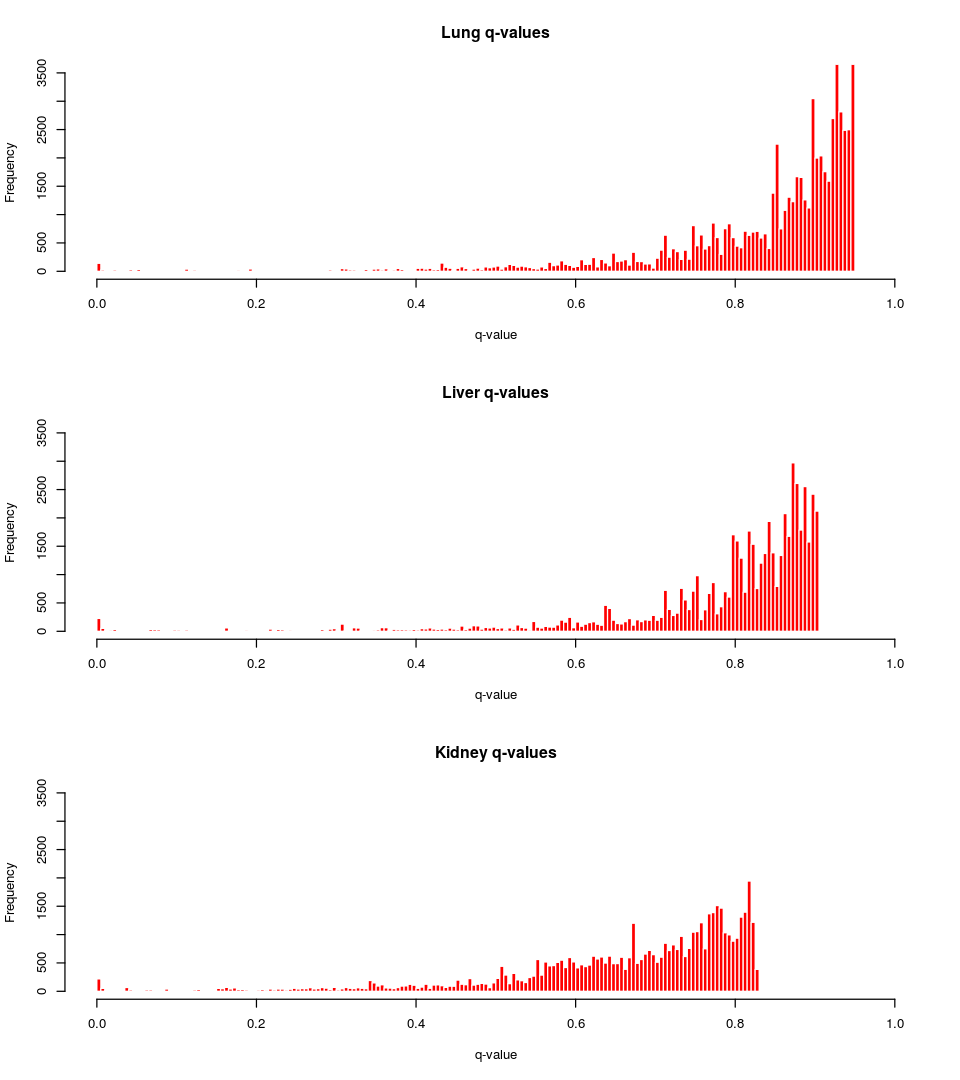

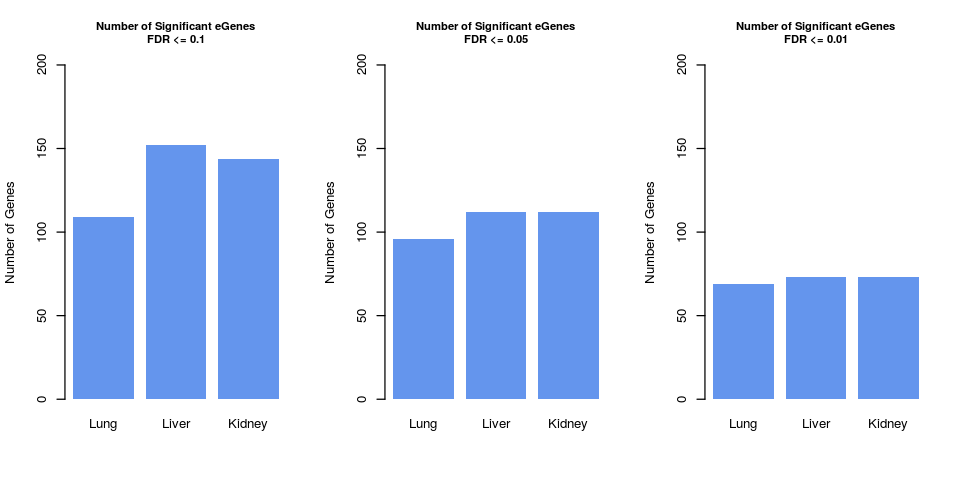

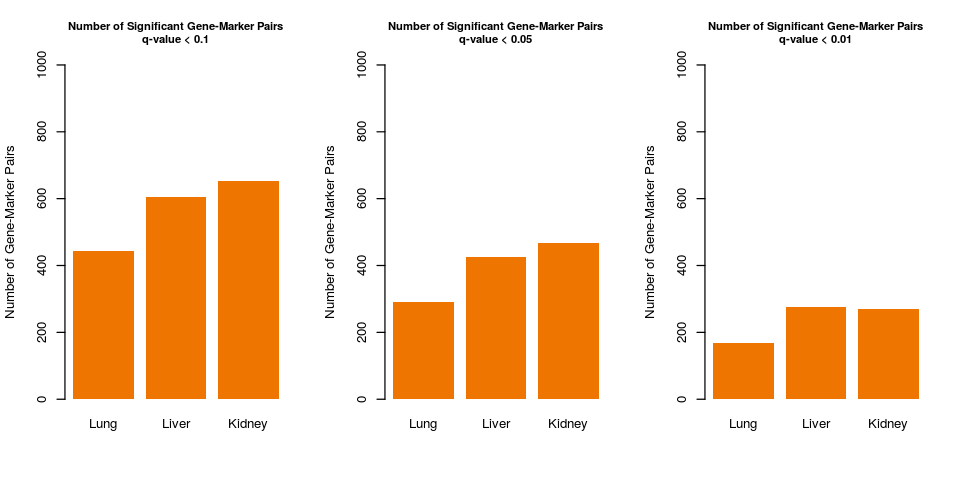

In [3]:
library(repr)

#P-value distributions
options(repr.plot.width=8, repr.plot.height=9)
par(mfrow=c(3,1))
hist(as.numeric(qvals.lung$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Lung q-values",
     ylab="Frequency",
     xlab="q-value")
hist(as.numeric(qvals.liver$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Liver q-values",
     ylab="Frequency", 
     xlab="q-value")
hist(as.numeric(qvals.kidney$qvalues), breaks=200, freq=T, ylim=c(0,3500), xlim=c(0,1),
     col="red", border="white",
     main="Kidney q-values",
     ylab="Frequency", 
     xlab="q-value")


#Calculate significant eGenes and gene marker pairs
for(cutoff in c(0.1,0.05,0.01)){
    num.egenes.lung <- length(which(gene.qval.lung$qvalues<cutoff))
    num.egenes.liver <- length(which(gene.qval.liver$qvalues<cutoff))
    num.egenes.kidney <- length(which(gene.qval.kidney$qvalues<cutoff))
    assign(x=paste0("num.egenes.",cutoff),value=c(num.egenes.lung, num.egenes.liver, num.egenes.kidney))

    num.sig.lung <- length(which(qvals.lung$qvalues<cutoff))
    num.sig.liver <- length(which(qvals.liver$qvalues<cutoff))
    num.sig.kidney <- length(which(qvals.kidney$qvalues<cutoff))
    assign(x=paste0("num.sig.",cutoff),value=c(num.sig.lung, num.sig.liver, num.sig.kidney))
}

#Significant eGenes
options(repr.plot.width=8, repr.plot.height=4)
par(mfrow=c(1,3))
barplot(height=num.egenes.0.1, beside=T, ylab="Number of Genes", ylim=c(0,200),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.1",
        cex.main=0.85)
barplot(height=num.egenes.0.05, beside=T, ylab="Number of Genes", ylim=c(0,200),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.05",
        cex.main=0.85)
barplot(height=num.egenes.0.01, beside=T, ylab="Number of Genes", ylim=c(0,200),
        border=NA, col="cornflowerblue",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant eGenes\nFDR <= 0.01",
        cex.main=0.85)


#Significant gene marker paris
par(mfrow=c(1,3))
barplot(height=num.sig.0.1, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.1",
        cex.main=0.85)
barplot(height=num.sig.0.05, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.05",
        cex.main=0.85)
barplot(height=num.sig.0.01, beside=T, ylab="Number of Gene-Marker Pairs", ylim=c(0,1000),
        border=NA, col="darkorange2",
        names.arg=c("Lung","Liver","Kidney"), 
        main="Number of Significant Gene-Marker Pairs\nq-value < 0.01",
        cex.main=0.85)

## Retrieving most significant associations

For each tissue, we retrieve the 100 gene-marker pairs that produced the most significant q-values and list them below. Notably, not all the records listed have q-values that would pass typical thresholds.

In [4]:
#Load marker coordinates and gene expression data
tmp.env <- new.env()
load("data/625ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.lung <- tmp.data$exp.mat
marker.map <- tmp.data$marker.map
load("data/625ppm_vs_1500ppm_liver.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.liver <- tmp.data$exp.mat
load("data/625ppm_vs_1500ppm_kidney.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
rna.levels.kidney <- tmp.data$exp.mat
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.list <- cbind(pvals.lung, qval=qvals.lung$qvalues)
lung.list <- lung.list[order(lung.list$qval),]
liver.list <- cbind(pvals.liver, qval=qvals.liver$qvalues)
liver.list <- liver.list[order(liver.list$qval),]
kidney.list <- cbind(pvals.kidney, qval=qvals.kidney$qvalues)
kidney.list <- kidney.list[order(kidney.list$qval),]
top.lung.list <- lung.list[1:100,]
top.liver.list <- liver.list[1:100,]
top.kidney.list <- kidney.list[1:100,]

#Get genomic coordinates for top markers
get.location <- function(marker, marker.map){
    boundary.markers <- unlist(strsplit(x=marker, split=".", fixed=T))
    m.index1 <- which(marker.map$marker==boundary.markers[1])
    m.index2 <- which(marker.map$marker==boundary.markers[2])
    if(length(m.index1)!=1 | length(m.index2)!=1){
        error_msg <- paste0("Error: Marker not found in marker map: ", marker)
        stop(error_msg)
    }
    #Get marker region
    m1 <- marker.map[m.index1,]
    m2 <- marker.map[m.index2,]
    if(m1$chromosome!=m2$chromosome){stop("Error: Markers merged across chromosomes!")}
    m.region <- c(m1$chromosome, m1$position, m2$position)
    return(m.region)
}
top.lung.list <- cbind(top.lung.list, t(sapply(as.character(top.lung.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.liver.list <- cbind(top.liver.list, t(sapply(as.character(top.liver.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
top.kidney.list <- cbind(top.kidney.list, t(sapply(as.character(top.kidney.list$marker), get.location, marker.map=marker.map)))[,c(1,2,5,6,7,3,4)]
colnames(top.lung.list)[3:5] <- c("chr", "start", "end")
colnames(top.liver.list)[3:5] <- c("chr", "start", "end")
colnames(top.kidney.list)[3:5] <- c("chr", "start", "end")

#Get gene expression statistics
gene.calc <- function(gene, expression){
    abundance <- expression[,colnames(expression)==gene]
    return(c(mean(abundance), sd(abundance), range(abundance)))
}
gene.stats.lung <- t(sapply(top.lung.list$gene, gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(top.liver.list$gene, gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(top.kidney.list$gene, gene.calc, expression=rna.levels.kidney))
top.lung.list <- cbind(top.lung.list, gene.stats.lung)
top.liver.list <- cbind(top.liver.list, gene.stats.liver)
top.kidney.list <- cbind(top.kidney.list, gene.stats.kidney)
colnames(top.lung.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.liver.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.kidney.list)[8:11] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")

#Display tables
cat("Lung\n")
top.lung.list
cat("Liver\n")
top.liver.list
cat("Kidney\n")
top.kidney.list

#Write tables to file
write.table(x=top.lung.list, file="results/lung_top100_hits_adjusted_pvals_625_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.liver.list, file="results/liver_top100_hits_adjusted_pvals_625_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")
write.table(x=top.kidney.list, file="results/kidney_top100_hits_adjusted_pvals_625_vs_1500.txt", 
            quote=F, row.names=F, col.names=T, sep="\t")


Lung


gene          marker                        chr   start     end      
11787 Glipr2        UNC041043835.JAX00549124      chr4  42893122  43420015 
11840 Glipr2        UNC7134471.UNC7149801         chr4  43435464  44471396 
11887 Glipr2        UNC7150041.UNC040499102       chr4  44482964  45420044 
32976 Gm7257        UNC16151938.UNC16154080       chr9  35113489  35268245 
32991 Gm7257        UNC16154532.UNC16154532       chr9  35291260  35291260 
33006 Gm7257        UNC16154850.UNC16154850       chr9  35308072  35308072 
33020 Gm7257        JAX00169998.JAX00169998       chr9  35315689  35315689 
33042 Gm7257        UNC16155218.UNC16176492       chr9  35333084  37377135 
65245 Gm6812        UNC30902191.UNC30940542       chrX  61801391  67641752 
18562 Mir7035       UNC10247043.UNC10251963       chr5  136258327 136611946
65243 Gm1140        UNC30902191.UNC30940542       chrX  61801391  67641752 
12566 Dhcr24        JAX00122955.UNC7931463        chr4  106754201 106907260
12594 Dhcr24        JAX00561354.JAX00561354       chr4  106991042 106991042
12624 Dhcr24        UNC7932936.UNC7947729         chr4  107007905 108092055
12530 Dhcr24        UNC7905375.UNC040215368       chr4  105050114 105593993
12542 Dhcr24        UNC7913411.UNC7928876         chr4  105636559 106692080
46245 Tnfaip2       UNC21894871.UNC21910865       chr12 112701505 113755394
12127 Baat          UNC7220972.UNC7228380         chr4  50055241  50751015 
54    Lactb2        UNC119817.UNC123662           chr1  12361315  12731062 
61    Lactb2        UNC130265.UNC134669           chr1  13154530  13530989 
57    Lactb2        JAX00242146.UNC129874         chr1  12788026  13120045 
12510 Tctex1d1      UNC7873851.UNC7888795         chr4  102753749 103864654
12488 Tctex1d1      JAX00559819.UNC7858732        chr4  101182928 101688775
12499 Tctex1d1      UNC7859499.UNC7873155         chr4  101742674 102686507
18216 Mmp17         UNC051739102.UNC10159778      chr5  128992514 130159208
33049 Olfr889       UNC16155218.UNC16176492       chr9  35333084  37377135 
33096 Olfr889       UNC16190786.JAX00691103       chr9  38399972  40032862 
33074 Olfr889       UNC16177202.UNC16189957       chr9  37440457  38326154 
12447 Hook1         UNC7778493.UNC7800092         chr4  95319709  97179525 
57175 Mir6971       UNC27787139.UNC27801007       chr17 32890762  34208805 
⋮     ⋮             ⋮                             ⋮     ⋮         ⋮        
12963 Edn2          UNC8089729.UNC8093800         chr4  119565064 119868269
22759 Nlrp12        UNC12370256.UNC12372829       chr7  3419749   3600642  
22807 Nlrp12        UNC12373496.UNC12373496       chr7  3666894   3666894  
22865 Nlrp12        UNC070002187.JAX00190001      chr7  3766660   4302475  
24163 Hipk4         UNC12537732.UNC12538865       chr7  28590780  28671768 
415   Lonrf2        UNC495144.UNC506607           chr1  39576376  40300255 
24049 Hipk4         UNC12532252.JAX00633908       chr7  28182026  28260270 
380   Lonrf2        UNC474803.UNC486654           chr1  38274756  39036913 
24104 Hipk4         JAX00190043.JAX00149594       chr7  28310064  28545803 
54433 Stfa1         UNC26653811.UNC26655798       chr16 36841001  37082528 
54469 Stfa1         UNC160204180.UNC26667086      chr16 37102047  38320325 
25889 A230056P14Rik UNC070508775.UNC12924281      chr7  64021992  64952054 
46310 BC022687      UNC21918598.UNC21918598       chr12 114338692 114338692
189   4931408C20Rik JAX00001782.UNC340151         chr1  26970988  27730678 
188   4931408C20Rik JAX00245123.JAX00245123       chr1  26810245  26810245 
186   4931408C20Rik UNC309997.JAX00245113         chr1  25659600  26757386 
54429 Parp14        UNC26653811.UNC26655798       chr16 36841001  37082528 
52873 Arf3          JAX00411603.UNC26210817       chr15 98939549  99463581 
27417 Ears2         UNC13732476.UNC13752913       chr7  127205649 129209759
52929 Arf3          UNC26210905.UNC26211240       chr15 99470609  99513852 
25845 4933405O20Rik B6_07_057450823_S.UNC12833808 chr7

Liver


gene          marker                        chr   start     end      
45245 2010005H15Rik UNC26653811.UNC26655798       chr16 36841001  37082528 
16133 Flt1          UNC10397110.JAX00136998       chr5  148245747 148314277
16144 Flt1          UNC10397739.JAX00600890       chr5  148324065 148441915
16198 Flt1          UNC10406187.UNC050249355      chr5  148817491 148835635
16245 Flt1          UNC10419602.UNC10428605       chr5  149471600 150017329
31717 Mettl7b       JAX00302230.UNC18984159       chr10 127068725 129453534
30623 Gstt3         UNC18201974.UNC18243811       chr10 70820186  74518605 
16187 Flt1          UNC10404645.UNC10405837       chr5  148750496 148801107
15828 Mrm2          UNC10310084.JAX00599550       chr5  141247806 141257164
9578  1110017D15Rik UNC7118700.UNC7124415         chr4  41024926  41707785 
9619  1110017D15Rik UNC040438036.UNC7124648       chr4  41753417  42885529 
9547  1110017D15Rik UNC7110872.UNC7118338         chr4  40418848  40997848 
39280 Nfil3         UNC22598191.UNC22613247       chr13 52306795  53193329 
39270 Nfil3         JAX00357912.JAX00357963       chr13 52194752  52291750 
14933 Tbx3os2       UNC10014758.UNC10018900       chr5  119329120 119680504
741   Ccdc108       UNC932547.UNC939418           chr1  73462140  74011896 
16100 Lnx2          UNC10384922.UNC10385552       chr5  147505087 147535570
16190 Lnx2          UNC10404645.UNC10405837       chr5  148750496 148801107
16179 Lnx2          UNC10402752.JAX00600937       chr5  148645194 148735792
16136 Lnx2          UNC10397110.JAX00136998       chr5  148245747 148314277
16157 Lnx2          JAX00600891.UNC10401202       chr5  148442078 148543242
16168 Lnx2          UNC10401431.JAX00600911       chr5  148558533 148641792
3839  Lcn8          UNC2769757.JAX00092398        chr2  26408983  26731528 
16147 Lnx2          UNC10397739.JAX00600890       chr5  148324065 148441915
16201 Lnx2          UNC10406187.UNC050249355      chr5  148817491 148835635
16076 Lnx2          UNC050433302.UNC10384598      chr5  145958559 147485695
16214 Lnx2          UNC10406637.UNC10414582       chr5  148841878 149187563
15812 Mrm2          JAX00599512.UNC10309656       chr5  141158294 141209528
970   Platr5        JAX00258020.UNC1103435        chr1  88609381  90627755 
1000  Platr5        UNC1104334.UNC1136443         chr1  90678542  92876429 
⋮     ⋮             ⋮                             ⋮     ⋮         ⋮        
45051 Gm20319       UNC26509230.UNC26542096       chr16 25876885  27974227 
30571 4930545H06Rik UNC18153616.JAX00291896       chr10 67576512  68587972 
30647 Gstt3         UNC18245269.UNC18248787       chr10 74622152  74972054 
54604 6030498E09Rik JAX00178139.JAX00710854       chrX  35887961  40064572 
47344 Cdkn1a        UNC27753023.UNC27767093       chr17 30047121  31280270 
45474 Adgrg7        UNC26895260.JAX00422198       chr16 57292671  58258314 
1742  Angptl1       JAX00272462.UNC2022940        chr1  157832803 159471172
1247  Il10          backupJAX00266606.UNC1671642  chr1  131706524 132438206
1262  Il10          UNC1672080.UNC1672968         chr1  132485471 132579069
1279  Il10          UNC1673446.UNC1685429         chr1  132626451 133649000
1305  Il10          UNC1685599.backupUNC010608551 chr1  133661417 134411810
47322 Fkbp5         JAX00435265.UNC27752624       chr17 29253980  30011091 
1756  Angptl1       UNC2023679.UNC2030766         chr1  159531480 160115744
47317 Cdkn1a        JAX00435265.UNC27752624       chr17 29253980  30011091 
31181 Ube2n         UNC18475040.UNC18480813       chr10 94227755  94633926 
9531  Zfp292        UNC7054545.UNC7060540         chr4  35777302  36390021 
16122 Flt1          UNC10395292.UNC10397004       chr5  148123975 148235274
31613 Apof          UNC18954707.UNC18961845       chr10 126429359 127050365
16111 Flt1          UNC10385644.UNC10395146       chr5  147542116 148105914
9527  Zfp292        UNC7051473.JAX00548318        chr4  35418782  35769492 
31683 Apof          JAX00302230.UNC18984159       chr1

Kidney


gene          marker                                chr   start    
41520 Gm933         UNC26571789.UNC26602350               chr16 29937453 
8762  Gne           UNC041043835.JAX00549124              chr4  42893122 
8802  Gne           UNC7134471.UNC7149801                 chr4  43435464 
8835  Gne           UNC7150041.UNC040499102               chr4  44482964 
14673 5930430L01Rik UNC10415636.UNC10419468               chr5  149249649
14686 5930430L01Rik UNC10419602.UNC10428605               chr5  149471600
14700 5930430L01Rik UNC10429359.JAX00137288               chr5  150071451
3746  Mir2861       JAX00486759.UNC2842985                chr2  32759265 
14260 Mir339        UNC10283765.UNC10290586               chr5  139270508
50169 Gm14692       UNC30902191.UNC30940542               chrX  61801391 
41543 Gm933         UNC160202433.UNC160203517             chr16 32695806 
41564 Gm933         UNC26606735.UNC160297022              chr16 32984923 
41585 Gm933         UNC26611901.UNC26632751               chr16 33349818 
13855 Zbed5         UNC10173561.UNC10177662               chr5  131157768
6046  Gm14288       UNC4549947.UNC4556034                 chr2  173880924
6059  Gm14288       UNC4556542.UNC4558476                 chr2  174406645
6072  Gm14288       JAX00512370.JAX00512441               chr2  174571924
28574 Gm4489        UNC18891985.UNC18899775               chr10 122460228
18685 Ffar1         UNC12572462.UNC12573732               chr7  31229864 
35740 1700011B04Rik backupJAX00354324.JAX00354524         chr13 33163208 
35759 1700011B04Rik UNC22394212.JAX00354999               chr13 34521187 
25156 Robo3         UNC16177202.UNC16189957               chr9  37440457 
25000 Thyn1         JAX00169417.JAX00169430               chr9  27554428 
25145 Robo3         UNC16155218.UNC16176492               chr9  35333084 
39256 Peg13         UNC25865603.JAX00063539               chr15 72289280 
39261 Peg13         UNC25868932.JAX00405405               chr15 72551229 
39283 Peg13         UNC25871106.UNC25886541               chr15 72712691 
39246 Peg13         UNC25858074.UNC25863874               chr15 71760277 
39251 Peg13         UNC25864050.UNC25865397               chr15 72169938 
4210  Nup35         UNC3371968.UNC3427549                 chr2  76913048 
⋮     ⋮             ⋮                                     ⋮     ⋮        
7040  Npr1          UNC5732520.UNC5752814                 chr3  88658882 
17478 Peg3          UNC12382380.UNC070621878              chr7  4769650  
39273 Kcnk9         UNC25871106.UNC25886541               chr15 72712691 
8843  Pax5          UNC7150041.UNC040499102               chr4  44482964 
14646 5930430L01Rik UNC10406637.UNC10414582               chr5  148841878
14660 5930430L01Rik JAX00601111.UNC10415285               chr5  149189724
8652  Gm13305       UNC7118700.UNC7124415                 chr4  41024926 
8800  Gm13305       UNC7134471.UNC7149801                 chr4  43435464 
8757  Gm13305       UNC041043835.JAX00549124              chr4  42893122 
8707  Gm13305       UNC040438036.UNC7124648               chr4  41753417 
18707 Nfkbid        UNC12572462.UNC12573732               chr7  31229864 
8811  Pax5          UNC7134471.UNC7149801                 chr4  43435464 
13980 Dnajc30       UNC10239614.JAX00598489               chr5  135749244
41709 Fbxo40        UNC160204180.UNC26667086              chr16 37102047 
41686 Fbxo40        UNC26653811.UNC26655798               chr16 36841001 
14079 Ap1s1         UNC10247043.UNC10251963               chr5  136258327
39007 Polr2k        UNC25371045.UNC25387593               chr15 36380518 
2405  Mir1981       UNC2366861.JAX00279382                chr1  187537488
18056 Cyp2b13       UNC12521377.UNC12521377               chr7  27033384 
16824 Dusp16        UNC12149808.UNC12166947               chr6  135036358
22392 Tpte          UNC14299130.UNC14299130               chr8  23494517 
22374 Tpte          UNC14296105.UNC14298810               chr8  23277824 
22322 Tpte

## Retrieving significant eGenes

For each tissue, we retrieve significant eGenes (FDR <= 0.1) and list them below.

In [5]:
#Load gene coordinates
tmp.env <- new.env()
load("data/625ppm_vs_1500ppm_lung.Rdata", envir=tmp.env)
tmp.data <- get("inp", tmp.env)
gene.map <- tmp.data$cis.map #GenomicRanges object
rm(tmp.env, tmp.data)

#Make data frame of sorted results and subset
lung.gene.list <- data.frame(gene.pval.lung, qval=gene.qval.lung$qvalues)
lung.gene.list <- lung.gene.list[order(lung.gene.list$qval),]
liver.gene.list <- data.frame(gene.pval.liver, qval=gene.qval.liver$qvalues)
liver.gene.list <- liver.gene.list[order(liver.gene.list$qval),]
kidney.gene.list <- data.frame(gene.pval.kidney, qval=gene.qval.kidney$qvalues)
kidney.gene.list <- kidney.gene.list[order(kidney.gene.list$qval),]
colnames(lung.gene.list) <- c("pval","qval")
colnames(liver.gene.list) <- c("pval","qval")
colnames(kidney.gene.list) <- c("pval","qval")
top.genes.lung <- lung.gene.list[which(lung.gene.list$qval<=0.1),]
top.genes.liver <- liver.gene.list[which(liver.gene.list$qval<=0.1),]
top.genes.kidney <- kidney.gene.list[which(kidney.gene.list$qval<=0.1),]

#Get gene locations
locations.lung <- sapply(rownames(top.genes.lung), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.liver <- sapply(rownames(top.genes.liver), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
locations.kidney <- sapply(rownames(top.genes.kidney), function(x, map){as.character(map[which(map$gene==x),])}, map=gene.map)
top.genes.lung <- cbind(top.genes.lung, locations.lung)
top.genes.liver <- cbind(top.genes.liver, locations.liver)
top.genes.kidney <- cbind(top.genes.kidney, locations.kidney)
colnames(top.genes.lung)[3] <- "coordinate"
colnames(top.genes.liver)[3] <- "coordinate"
colnames(top.genes.kidney)[3] <- "coordinate"

#Get gene expression statistics
gene.stats.lung <- t(sapply(rownames(top.genes.lung), gene.calc, expression=rna.levels.lung))
gene.stats.liver <- t(sapply(rownames(top.genes.liver), gene.calc, expression=rna.levels.liver))
gene.stats.kidney <- t(sapply(rownames(top.genes.kidney), gene.calc, expression=rna.levels.kidney))
top.genes.lung <- cbind(top.genes.lung, gene.stats.lung)
top.genes.liver <- cbind(top.genes.liver, gene.stats.liver)
top.genes.kidney <- cbind(top.genes.kidney, gene.stats.kidney)
colnames(top.genes.lung)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.liver)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")
colnames(top.genes.kidney)[4:7] <- c("mean.expression", "sd.expression", "min.expression","max.exprresion")


#Display tables
cat("Lung\n")
top.genes.lung
cat("Liver\n")
top.genes.liver
cat("Kidney\n")
top.genes.kidney

#Write tables to file
write.table(x=top.genes.lung, file="results/lung_egenes_625_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.liver, file="results/liver_egenes_625_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")
write.table(x=top.genes.kidney, file="results/kidney_egenes_625_vs_1500.txt", 
            quote=F, row.names=T, col.names=T, sep="\t")


Lung


pval         qval         coordinate               
Glipr2        2.494310e-64 3.794595e-60 chr4:42970573-44970574   
Gm7257        4.345432e-51 3.305353e-47 chr9:35239468-37239469   
Gm6812        1.104936e-39 5.603130e-36 chrX:65146227-67146228   
Mir7035       1.676658e-34 6.376750e-31 chr5:135581391-137581392 
Gm1140        5.804616e-30 1.766113e-26 chrX:63959524-65959525   
Dhcr24        1.051000e-27 2.664811e-24 chr4:105233642-107233643 
Tnfaip2       6.222842e-26 1.352401e-22 chr12:111680871-113680872
Baat          5.926062e-25 1.126915e-21 chr4:48519429-50519430   
Lactb2        5.368392e-23 9.074372e-20 chr1:12650589-14650590   
Tctex1d1      2.393236e-21 3.640830e-18 chr4:101658983-103658984 
Mmp17         1.107453e-17 1.531608e-14 chr5:129090043-131090044 
Olfr889       1.772094e-17 2.246572e-14 chr9:36923382-38923383   
Hook1         4.173328e-17 4.883757e-14 chr4:94634069-96634070   
Mir6971       7.388086e-17 8.028211e-14 chr17:33978815-35978816  
Snord52       6.779847e-16 6.876121e-13 chr17:34087952-36087953  
Gm9999        3.035598e-15 2.886284e-12 chr7:53232001-55232002   
Fbn1          6.818502e-15 6.101757e-12 chr2:124332173-126332174 
Tcl1b1        1.337578e-14 1.130476e-11 chr12:105397913-107397914
Nipa2         8.643563e-14 6.920765e-11 chr7:62217862-64217863   
Mir1956       1.267515e-13 9.641355e-11 chr3:137189384-139189385 
Reck          4.391489e-13 3.181320e-10 chr4:42888401-44888402   
Olfr145       4.727846e-13 3.269306e-10 chr9:36704990-38704991   
Ndufb4        8.674081e-13 5.737339e-10 chr16:36654453-38654454  
Ssna1         9.454772e-13 5.993144e-10 chr2:24127937-26127938   
Hkdc1         3.935380e-12 2.394757e-09 chr10:60885204-62885205  
Jmjd7         1.869994e-11 1.094162e-08 chr2:118853218-120853219 
Gm4791        4.074906e-11 2.295983e-08 chr9:45806823-47806824   
Pole2         1.069601e-10 5.811372e-08 chr12:69329176-71329177  
Obp2a         1.652981e-10 8.671311e-08 chr2:24555593-26555594   
2310079G19Rik 4.144852e-10 2.101854e-07 chr16:87627910-89627911  
⋮             ⋮            ⋮            ⋮                        
1700016D06Rik 0.0001341062 0.02525765   chr8:10678749-12678750   
4930573O16Rik 0.0001344817 0.02525765   chr2:51146521-53146522   
Mtfr2         0.0001392881 0.02584134   chr10:19067624-21067625  
Atp1a3        0.0001412716 0.02589356   chr7:24790955-26790956   
Zfp109        0.0001496952 0.02711086   chr7:24022616-26022617   
Snhg7         0.0001562722 0.02796904   chr2:25495763-27495764   
Popdc3        0.0001660757 0.02937803   chr10:44009110-46009111  
Pcsk1n        0.0001729477 0.03024199   chrX:6496947-8496948     
Gm10684       0.0001753588 0.03031516   chr9:43943688-45943689   
Icosl         0.0001933077 0.03304259   chr10:76532112-78532113  
Scgb2b2       0.0002026390 0.03425275   chr7:31087787-33087788   
4921509O07Rik 0.0002271018 0.03796592   chr13:113293051-115293052
Clrn2         0.0002429775 0.03974641   chr5:44844989-46844990   
Slc37a4       0.0002425637 0.03974641   chr9:43205009-45205010   
Arl4a         0.0002567586 0.04155391   chr12:39764573-41764574  
Aspn          0.0002743462 0.04393294   chr13:48639811-50639812  
Kir3dl1       0.0002820384 0.04469428   chrX:132052537-134052538 
Tmsb15a       0.0003702112 0.05806209   chrX:131255211-133255212 
Fkbp5         0.0004024071 0.06246755   chr17:27623093-29623094  
Mir759        0.0004105874 0.06309360   chr14:79138237-81138238  
Ly9           0.0004482204 0.06818777   chr1:172537540-174537541 
Oxnad1        0.0004581082 0.06900198   chr14:31898913-33898914  
Gramd1c       0.0004905506 0.07316418   chr16:43028057-45028058  
Dnaaf2        0.0005357798 0.07913416   chr12:69299415-71299416  
Gm11961       0.0006005530 0.08701155   chr11:3530013-5530014    
Plekha6       0.0005952710 0.08701155   chr1:134142673-136142674 
Btnl4         0.0006630700 0.09516306   chr17:33612881-35612882  
Zfp60         0.0006732451 0.09572035   chr7:27516427-29516428   
Ninl          0.0007056967 0.09934019   chr2:149835133

Liver


pval         qval         coordinate               
2010005H15Rik 4.268591e-64 3.955029e-60 chr16:35221647-37221648  
Flt1          6.305850e-64 3.955029e-60 chr5:147537563-149537564 
Mettl7b       3.778385e-62 1.579869e-58 chr10:127398043-129398044
Gstt3         3.404848e-37 1.067760e-33 chr10:74244158-76244159  
Mrm2          1.902214e-29 4.772274e-26 chr5:139807851-141807852 
1110017D15Rik 8.010011e-27 1.674626e-23 chr4:40464365-42464366   
Nfil3         1.407119e-25 2.521557e-22 chr13:52076407-54076408  
Tbx3os2       1.242579e-21 1.948364e-18 chr5:119141226-121141227 
Ccdc108       3.906474e-20 5.444756e-17 chr1:73982172-75982173   
Lnx2          4.570167e-19 5.732817e-16 chr5:146888147-148888148 
Lcn8          2.472372e-16 2.819403e-13 chr2:24508637-26508638   
Platr5        1.889431e-15 1.975085e-12 chr1:89651464-91651465   
LOC100861615  2.257212e-14 2.178036e-11 chr14:2049307-4049308    
Dhrs7         6.358885e-14 5.697561e-11 chr12:72765814-74765815  
Inhbe         7.844092e-14 6.559753e-11 chr10:125788903-127788904
Tmem52b       1.275647e-13 1.000108e-10 chr6:128462574-130462575 
Btg1          6.928123e-13 5.112139e-10 chr10:95079634-97079635  
Nfe2l2        7.116350e-12 4.959305e-09 chr2:74542719-76542720   
3110043O21Rik 8.193005e-12 5.409108e-09 chr4:34173128-36173129   
Crcp          3.841642e-11 2.409478e-08 chr5:129505175-131505176 
Hsd17b6       7.884721e-11 4.709807e-08 chr10:126444563-128444564
E2f7          4.615955e-10 2.631934e-07 chr10:109182520-111182521
4930545H06Rik 8.473814e-10 4.621544e-07 chr10:66783889-68783890  
Tmem184a      1.103959e-09 5.770027e-07 chr5:139290236-141290237 
Gm20319       6.109484e-09 3.065494e-06 chr16:25755587-27755588  
B3gnt4        6.604100e-09 3.186224e-06 chr5:122960468-124960469 
Vwf           1.009740e-08 4.691177e-06 chr6:124502965-126502966 
6030498E09Rik 1.351707e-08 6.055646e-06 chrX:35125956-37125957   
Cdkn1a        1.426537e-08 6.170510e-06 chr17:28227923-30227924  
Adgrg7        1.569619e-08 6.563101e-06 chr16:55795970-57795971  
⋮             ⋮            ⋮            ⋮                        
Wbscr27       0.0006232469 0.06356105   chr5:134408242-136408243 
Cox7b         0.0006442643 0.06517460   chrX:102211038-104211039 
Serpina5      0.0006639768 0.06663140   chr12:104339322-106339323
Gm8884        0.0006748362 0.06701147   chr9:47262444-49262445   
Zfp781        0.0006784484 0.06701147   chr10:80393224-82393225  
Mfsd7c        0.0007424736 0.07228263   chr12:86087488-88087489  
Tmem161a      0.0007433402 0.07228263   chr8:71696306-73696307   
Vkorc1l1      0.0007493057 0.07230224   chr5:129417978-131417979 
9330159M07Rik 0.0007665858 0.07340497   chr9:87753707-89753708   
Nes           0.0007782273 0.07395517   chr3:86775014-88775015   
Sec23a        0.0007994083 0.07539682   chr12:59113003-61113004  
5930430L01Rik 0.0008451199 0.07863606   chr5:148806790-150806791 
Dvl1          0.0008463165 0.07863606   chr4:154221425-155630120 
Ect2          0.0008525593 0.07863606   chr3:26052799-28052800   
Gm1987        0.0008683190 0.07950506   chr4:41231042-43231043   
Nrg1          0.0008871032 0.08063639   chr8:32028674-34028675   
Cacng6        0.0009324752 0.08354978   chr7:2425422-4425423     
Rims4         0.0009266473 0.08354978   chr2:162744418-164744419 
Micall2       0.0009391728 0.08355308   chr5:139212286-141212287 
Cav1          0.0009556307 0.08441854   chr6:16256334-18256335   
Gm12260       0.0009658525 0.08472485   chr11:57775212-59775213  
Pomc          0.0009783787 0.08522766   chr12:2954944-4954945    
Atg10         0.0009956349 0.08613272   chr13:90363591-92363592  
Grid1         0.0010102045 0.08679455   chr14:34633321-36633322  
6330418K02Rik 0.0010766419 0.09187344   chr5:137705272-139705273 
Cldn15        0.0011178991 0.09474951   chr5:136443738-138443739 
Rdh10         0.0011549978 0.09723686   chr1:15095962-17095963   
Kctd7         0.0011699133 0.09783595   chr5:129620757-131620758 
Psmg3         0.0011781368 0.09787118   chr5:139302796

Kidney


pval         qval         coordinate               
Gm933         4.202199e-86 4.862785e-82 chr16:31810531-33810532  
Gne           1.073022e-34 6.208505e-31 chr4:43097048-45097049   
5930430L01Rik 2.335300e-33 9.008032e-30 chr5:148806790-150806791 
Mir339        5.494829e-31 1.589654e-27 chr5:138845698-140845699 
Mir2861       9.681653e-31 2.240722e-27 chr2:31568407-33568408   
Gm14692       5.804616e-30 1.119517e-26 chrX:63959432-65959433   
Zbed5         2.501824e-26 4.135873e-23 chr5:129371592-131371593 
Gm14288       2.476396e-24 3.582106e-21 chr2:174100624-176100625 
Gm4489        1.412279e-21 1.815877e-18 chr10:120556752-122556753
Ffar1         1.078632e-19 1.248193e-16 chr7:30646488-32646489   
1700011B04Rik 8.874461e-19 9.335933e-16 chr13:34273491-36273492  
Robo3         1.106491e-17 1.067026e-14 chr9:36240759-38240760   
Thyn1         3.997594e-17 3.558474e-14 chr9:25807261-27807262   
Nup35         5.177900e-17 4.279904e-14 chr2:79478968-81478969   
Peg13         7.211936e-17 5.563768e-14 chr15:71640753-73640754  
Vrk2          7.598887e-16 5.495895e-13 chr11:25493919-27493920  
Dusp16        1.228078e-15 8.359596e-13 chr6:133742645-135742646 
Gm10377       3.729659e-14 2.397756e-11 chr14:42694108-44694109  
2010109I03Rik 1.454251e-13 8.857151e-11 chr15:73712133-75712134  
Best1         5.764268e-13 3.335206e-10 chr19:9076122-11076123   
Gm7861        1.414851e-11 7.796505e-09 chr8:21704936-23704937   
Nsun5         1.512050e-11 7.953383e-09 chr5:134845822-136845823 
Stfa1         4.038010e-11 2.031646e-08 chr16:35277233-37277234  
Chst12        1.714136e-10 8.264993e-08 chr5:139981562-141981563 
Syna          6.244325e-10 2.890373e-07 chr5:134036040-136036041 
Npr1          9.643771e-10 4.186700e-07 chr3:89269787-91269788   
Peg3          9.768484e-10 4.186700e-07 chr7:5683129-7683130     
Cyp2b13       1.326542e-09 5.324146e-07 chr7:25846513-27846514   
Tmem91        1.334257e-09 5.324146e-07 chr7:25460184-27460185   
Lynx1         1.382629e-09 5.333260e-07 chr15:73583408-75583409  
⋮             ⋮            ⋮            ⋮                        
Orai2         0.0005275549 0.05240121   chr5:135646525-137646526 
Pim1          0.0005327968 0.05240121   chr17:28627989-30627990  
Rdh13         0.0005250061 0.05240121   chr7:3397258-5397259     
Smim7         0.0005343366 0.05240121   chr8:74094946-76094947   
Emilin2       0.0005675982 0.05519535   chr17:70660304-72660305  
Eppk1         0.0005801210 0.05594300   chr15:74950624-76950625  
Trim12a       0.0006114434 0.05847622   chr7:110464008-112464009 
Rspo3         0.0006739948 0.06393006   chr10:28255672-30255673  
Sav1          0.0007369504 0.06933325   chr12:70087988-72087989  
Chrdl1        0.0007588537 0.06980157   chrX:138828804-140828805 
Gltp          0.0007597014 0.06980157   chr5:114140943-116140944 
Pim3          0.0007600240 0.06980157   chr15:87692623-89692624  
AI464131      0.0007715291 0.07030028   chr4:40450107-42450108   
Slc34a2       0.0008052114 0.07279615   chr5:52440591-54440592   
1700083H02Rik 0.0008180386 0.07338250   chr12:71485194-73485195  
Hebp1         0.0009065405 0.08069605   chr6:134118232-136118233 
Adamtsl5      0.0009340923 0.08127305   chr10:78811192-80811193  
Cbs           0.0009312474 0.08127305   chr17:30774149-32774150  
Sh2d1b2       0.0009340558 0.08127305   chr1:171163001-173163002 
Nsg1          0.0009431331 0.08144728   chr5:37550705-39550706   
4631405J19Rik 0.0009768532 0.08294841   chr2:91869504-93869505   
Rps8          0.0009715900 0.08294841   chr4:115828736-117828737 
Stau2         0.0009820197 0.08294841   chr1:15509382-17509383   
Zfp566        0.0010018159 0.08400734   chr7:29875528-31875529   
Bricd5        0.0010233261 0.08519374   chr17:23610828-25610829  
Mir350        0.0011423713 0.09442515   chr1:177702553-179702554 
Tmem144       0.0011511980 0.09447988   chr3:78646583-80646584   
5730408K05Rik 0.0011799117 0.09615449   chr19:7963259-9963260    
Adipoq        0.0012068124 0.09765897   chr16:22146608